<a href="https://colab.research.google.com/github/anmolsabharwal/RedDevils/blob/master/RD_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from google.colab import drive
import datetime
import plotly.figure_factory as ff


drive.mount('/content/drive')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
gws = sqlite3.connect('/content/drive/My Drive/fpl.db')
gws = pd.read_sql_query("SELECT * FROM gw",gws)
gws.head()


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Aaron_Cresswell,0,0,0,0,0,454,10,0,0,0,0,2016-08-15T19:00:00Z,0,4,0,0,0,0,1,0,14023,1,2,0,0,0,0,0,55,FALSE,0
1,Aaron_Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,0,0,0,0,1,0,13918,1,1,0,1,0,0,0,60,TRUE,0
2,Aaron_Ramsey,0,0,5,0,4.9,16,8,3,0,3,2.2,2016-08-14T15:00:00Z,60,9,0,0,0,0,1,0,163170,4,3,23,2,0,0,0,80,TRUE,0
3,Abdoulaye_Doucour�,0,0,0,0,0,482,7,0,0,0,0,2016-08-13T14:00:00Z,0,13,0,0,0,0,1,0,1051,1,1,0,0,0,0,0,50,FALSE,0
4,Abdul Rahman_Baba,0,0,0,0,0,80,10,0,0,0,0,2016-08-15T19:00:00Z,0,20,0,0,0,0,1,0,1243,1,2,0,0,0,0,0,55,TRUE,0


In [3]:
gws=gws.astype({'name':'category','assists':int,  'bonus':int, 'bps':int, 'clean_sheets':'category',
        'creativity':float,'element':int, 'goals_conceded':int,'goals_scored':int, 'ict_index':float, 'influence':float ,'minutes':int,  'penalties_missed':int, 'penalties_saved':int,
        'red_cards':int, 'round':int, 'saves':int, 'selected':int, 'team_a_score':int, 'team_h_score':int, 'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,'was_home':'category','value':float,'yellow_cards':int,'fixture':int,'opponent_team':int,'own_goals':int})

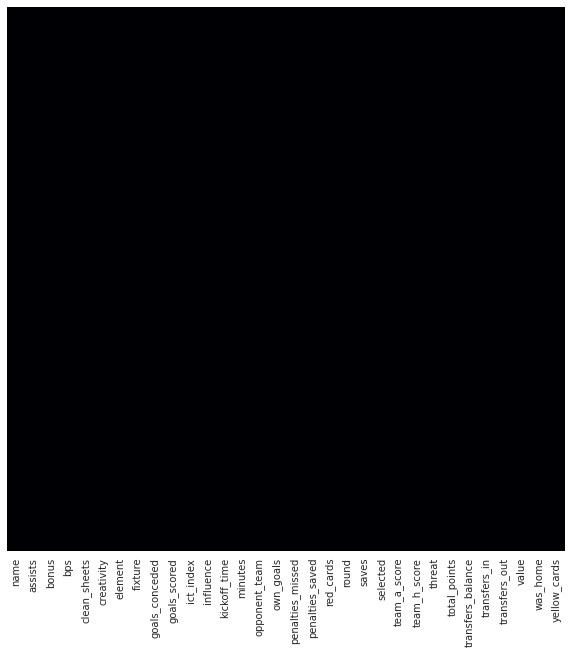

In [4]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno',)

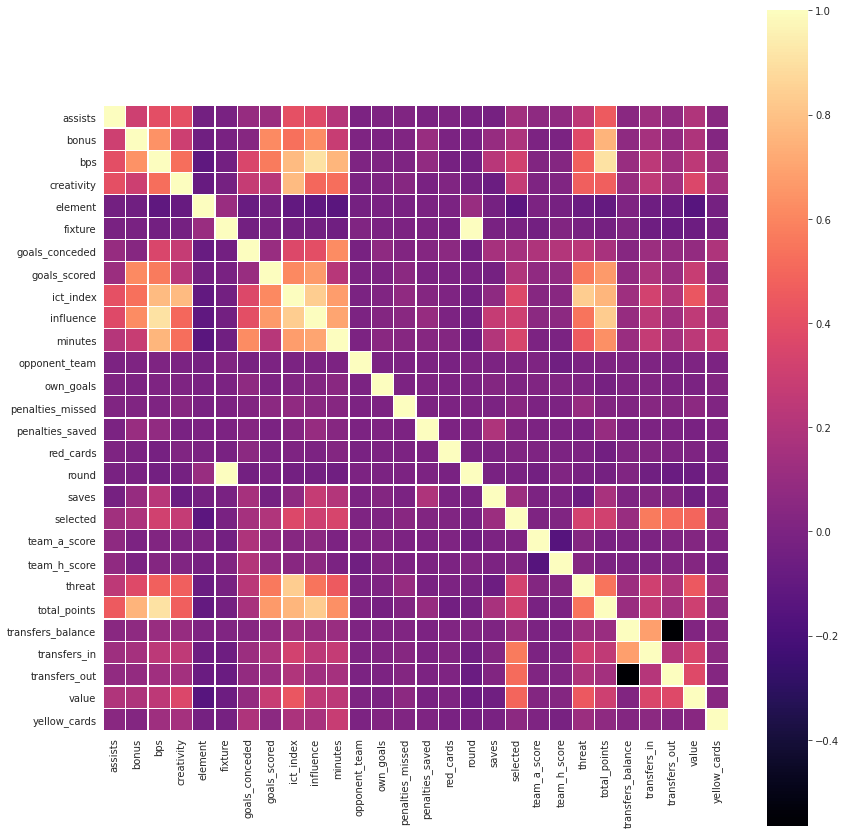

In [5]:
plt.figure(figsize=(14,15))
sns.heatmap(gws.corr(),cmap='magma',square=True, linewidths=0.2)

In [6]:
c=gws.corr().abs()
cor_target = c['total_points']
relevant_features = cor_target[cor_target>0.3]
relevant_features

assists         0.454511
bonus           0.750706
bps             0.906222
creativity      0.471431
goals_scored    0.664211
ict_index       0.759635
influence       0.831394
minutes         0.633654
selected        0.317268
threat          0.546717
total_points    1.000000
value           0.308994
Name: total_points, dtype: float64

In [7]:
upper = c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
to_drop=[column for column in upper.columns if any(upper[column] > 0.70)]
to_drop

['ict_index', 'influence', 'minutes', 'round', 'threat', 'total_points']

In [8]:
gws1=gws.drop(['ict_index', 'influence', 'minutes', 'round', 'threat'],axis=1)

In [9]:
#gws1.drop(['kickoff_time'], axis=1,inplace=True)

In [11]:
gws1['kickoff_time']=pd.to_datetime(gws1['kickoff_time'])

In [12]:
def was_home(x):
  if x=="FALSE":
    return 0
  else:
    return 1

In [13]:
gws1['home']=gws1['was_home'].apply(was_home)

In [14]:
gws1.drop('was_home',axis=1, inplace=True)

In [15]:
gws1['kickoff_time'] = gws1.kickoff_time.dt.hour


In [16]:
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [17]:
gws1['kickoff_time']=gws1['kickoff_time'].apply(time)


In [18]:
#gws1.drop(['kickoff_time_formatted'],axis=1,inplace=True)


In [19]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X=gws1.drop(['name','total_points'],axis=1)
y=gws1['total_points']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
#model.fit(X_train, y_train)
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
  print('Train: %s | test: %s' % (train_indices, test_indices))

[model.fit(X_train, y_train).score(X_test, y_test)
for train, test in k_fold.split(X)]

Train: [ 8381  8382  8383 ... 83802 83803 83804] | test: [   0    1    2 ... 8378 8379 8380]
Train: [    0     1     2 ... 83802 83803 83804] | test: [ 8381  8382  8383 ... 16759 16760 16761]
Train: [    0     1     2 ... 83802 83803 83804] | test: [16762 16763 16764 ... 25140 25141 25142]
Train: [    0     1     2 ... 83802 83803 83804] | test: [25143 25144 25145 ... 33521 33522 33523]
Train: [    0     1     2 ... 83802 83803 83804] | test: [33524 33525 33526 ... 41902 41903 41904]
Train: [    0     1     2 ... 83802 83803 83804] | test: [41905 41906 41907 ... 50282 50283 50284]
Train: [    0     1     2 ... 83802 83803 83804] | test: [50285 50286 50287 ... 58662 58663 58664]
Train: [    0     1     2 ... 83802 83803 83804] | test: [58665 58666 58667 ... 67042 67043 67044]
Train: [    0     1     2 ... 83802 83803 83804] | test: [67045 67046 67047 ... 75422 75423 75424]
Train: [    0     1     2 ... 75422 75423 75424] | test: [75425 75426 75427 ... 83802 83803 83804]


[0.9789013881335643,
 0.9789041454286603,
 0.9786613264426018,
 0.9789802488631019,
 0.9788627780118418,
 0.9789555831804886,
 0.9788654467981339,
 0.9787117869097214,
 0.9788221635344998,
 0.9788379906296231]

In [21]:
score=cross_val_score(model, X, y, cv=k_fold,scoring='r2')
score.mean()

0.9798078730756872

In [22]:
predict=model.predict(X_test)

In [23]:
predict

array([1.68, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])

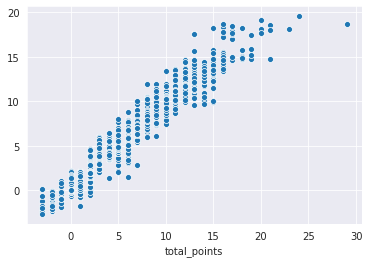

In [24]:
sns.scatterplot(y_test,predict)


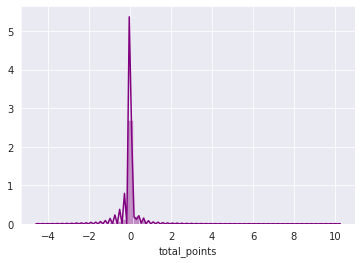

In [25]:
sns.distplot(y_test-predict,color='purple')

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
print('MAE:',mean_absolute_error(y_test,predict))
print('MSE:',mean_squared_error(y_test,predict))
print('RMSE',np.sqrt(mean_squared_error(y_test,predict)))
print('R2 Score',r2_score(y_test,predict))
#print('Adjusted R2 Score',1 - float(len(y_test)-1)/(len(y_test)-len(model.coef_)-1)*(1 - r2_score(y_test,predict))


MAE: 0.1289105878609498
MSE: 0.13694087582531222
RMSE 0.3700552334791554
R2 Score 0.9788379906296231


In [27]:
explained_variance_score(y_test,predict)

0.9788387685521656

In [28]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predict})


In [29]:
df.head(50)

,Actual,Predicted
35038,1,1.68
74222,0,0.00
20284,0,0.00
34391,0,0.00
80863,1,1.00
17715,0,0.00
80284,0,0.00
9272,0,0.00
8341,6,6.00
80194,3,2.85


In [41]:
x1=pd.read_csv('/content/drive/My Drive/GW29.csv',encoding = "ISO-8859-1")

In [49]:
x1.rename(columns={'ï»¿name':'name'},inplace=True)

In [50]:
x1.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Jorge Luiz_Frello Filho_118,0,0,0,0,0.0,118,283,0,0,0.0,0.0,2020-03-08T14:00:00Z,0,8,0,0,0,0,29,0,268799,0.0,4.0,0,0,-69728,1113,70841,49,True,0
1,Matej_Vydra_92,0,0,0,0,10.4,92,282,0,0,3.8,7.0,2020-03-07T17:30:00Z,22,17,0,0,0,0,29,0,15612,1.0,1.0,21,1,-3227,1885,5112,53,True,0
2,Brandon_Austin_558,0,0,0,0,0.0,558,282,0,0,0.0,0.0,2020-03-07T17:30:00Z,0,5,0,0,0,0,29,0,13625,1.0,1.0,0,0,-128,145,273,40,False,0
3,Lucas_Rodrigues Moura da Silva_345,0,0,7,0,21.3,345,282,0,0,4.2,9.0,2020-03-07T17:30:00Z,45,5,0,0,0,0,29,0,362915,1.0,1.0,12,1,-21942,11773,33715,71,False,0
4,John_Stones_207,0,0,0,0,0.0,207,287,0,0,0.0,0.0,2020-03-08T16:30:00Z,0,12,0,0,0,0,29,0,73701,0.0,2.0,0,0,944,1510,566,53,False,0


In [51]:
x1.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards'],
      dtype='object')

In [44]:
x1=x1.astype({'assists':int,  'bonus':int, 'bps':int, 'clean_sheets':'category',
        'creativity':float,'element':int, 'goals_conceded':int,'goals_scored':int, 'ict_index':float, 'influence':float ,'minutes':int,  'penalties_missed':int, 'penalties_saved':int,
        'red_cards':int, 'round':int, 'saves':int, 'selected':int, 'team_a_score':int, 'team_h_score':int, 'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,'was_home':'category','value':float,'yellow_cards':int,'fixture':int,'opponent_team':int,'own_goals':int})

ValueError: ignored

In [32]:
x1=x1.drop(['ict_index', 'influence', 'minutes', 'round', 'threat'],axis=1)

NameError: ignored

In [ ]:
x1.drop(['kickoff_time'], axis=1,inplace=True)

In [ ]:
x1['kickoff_time_formatted']=pd.to_datetime(x1['kickoff_time_formatted'])

In [ ]:
def was_home(x):
  if x=="FALSE":
    return 0
  else:
    return 1

In [ ]:
x1['home']=x1['was_home'].apply(was_home)

In [ ]:
x1.drop('was_home',axis=1, inplace=True)

In [ ]:
x1['kickoff_time'] = x1.kickoff_time_formatted.dt.hour


In [ ]:
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [ ]:
x1['kickoff_time']=x1['kickoff_time'].apply(time)


In [ ]:
x1.drop(['kickoff_time_formatted','GW'],axis=1,inplace=True)


In [ ]:
x1.columns

Index(['name', 'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'creativity', 'dribbles', 'element',
       'errors_leading_to_goal', 'errors_leading_to_goal_attempt', 'fixture',
       'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'id', 'minutes',
       'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score',
       'total_points', 'transfers_balance', 'transfers_out', 'value',
       'winning_goals', 'yellow_cards', 'home', 'kickoff_time'],
      dtype='object')

In [ ]:
x2=x1.drop(['total_points','name'],axis=1)
y_test1=x1['total_points']

In [ ]:
predict1=model.predict(x2)

In [ ]:
df1 = pd.DataFrame({'Actual': y_test1, 'Predicted': predict1})
df1.head(50)

,Actual,Predicted
0,0,0.00
1,3,2.88
2,2,1.75
3,1,1.00
4,12,12.03
5,0,0.00
6,3,3.00
7,1,1.00
8,1,1.00
9,0,0.00


In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
print('MAE:',mean_absolute_error(y_test1,predict1))
print('MSE:',mean_squared_error(y_test1,predict1))
print('RMSE',np.sqrt(mean_squared_error(y_test1,predict1)))
print('R2 Score',r2_score(y_test1,predict1))

MAE: 0.14649523809523812
MSE: 0.15327409523809524
RMSE 0.39150235661882704
R2 Score 0.9803077891731039
